In [1]:
import torch
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau



#define transfrom to the data
data_transform = transforms.Compose(
       [transforms.Resize((50,50)),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.406],
                             std=[0.225])
    ])

#import photo data 
cell_dataset = datasets.ImageFolder(root='../cell_images/',transform=data_transform)

data_transform = transforms.Compose(
       [transforms.Resize((50,50)),
        transforms.Grayscale(1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.406],
                             std=[0.225])
    ])

#import photo data 
cell_dataset = datasets.ImageFolder(root='../cell_images/',transform=data_transform)

#define dataloader
dataset_loader = DataLoader(cell_dataset,batch_size=4, shuffle=True,num_workers=4)


split1 = int(0.1 * len(cell_dataset))
split2 = int(0.9 * len(cell_dataset))
index_list = list(range(len(cell_dataset)))
np.random.shuffle(index_list) 
test_idx = index_list[:split1]+index_list[split2:]
train_idx=index_list[split1:split2]

## create training and validation sampler objects
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(test_idx)
#trainset=cell_dataset[split1:split2]

## create iterator objects for train and valid datasets
trainloader = DataLoader(cell_dataset, batch_size=16,sampler=tr_sampler,num_workers=1)
validloader = DataLoader(cell_dataset, batch_size=16,sampler=val_sampler,num_workers=1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 1, 50, 50])


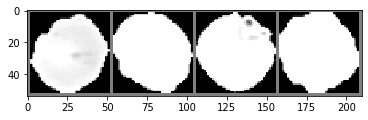

Uninfected Uninfected Parasitized Uninfected
tensor(1.2805)


In [35]:
# functions to show an image
classes=("Parasitized","Uninfected")

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataset_loader)
images, labels = dataiter.next()
#encode = autoencoder2(images)

print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

train_loader = iter(trainloader)
img, l = train_loader.next()

<h1>As it can be seen in the pictures, I sample the images down to 50x50 dimensions with torch transforms, I also convert them to grayscale.</h1>

<p>
    I don't train in the whole train set because it is pointless, the gradient vanishes super quickly in the first layers (convs), thus making training super hard. A solution for this would be to implement BatchNorm or ResBlocks, but for the time given this was all I could do.
</p>

<h3>
    <div style="color: red;">Look up:</div>
    <p>There is an if condition inside the for loop that breaks the training very early because I don't see the value in training with no vanishing gradient measures. (I am sure this is a vanishing gradient problem, because I have tested it with mnist too, for networks with 4-5+ layers, the gradient in the first convs goes down to values like 1e-9
</h3>

<h4>
    <div style="color: blue;">Clarification:</div>
    <p>In the C++ code and bindings there is also Model class exposed to Python, but I don't use it, because it makes the ipykernel crash without an explanation, that is why I have build the network as you can see below.</p>
</h4>

In [3]:
from libdl import DenseLayer, Convolution, MaxPool, ReLU, BinaryCrossEntropy, Sigmoid, TensorWrapper

conv1 = Convolution("conv1", 7, 16, 0, 1, 1, 16)
relu1 = ReLU()
#pool2 = MaxPool(2, 2)
conv2 = Convolution("conv2", 5, 16, 0, 1, 16, 16)
relu2 = ReLU()
pool1 = MaxPool(2, 2)
dense1 = DenseLayer(6400, 3000, "dense2", 10)
relu3 = ReLU()
dense2 = DenseLayer(3000, 200, "dense2", 10)
relu4 = ReLU()
dense3 = DenseLayer(200, 1, "dense3", 10)
sigmoid = Sigmoid()

binary_cross_entropy = BinaryCrossEntropy()

batch_size = 16
lr = 1e-5
epochs = 2

data = TensorWrapper(batch_size, 50, 50, 1, False)
labels = TensorWrapper(batch_size, 1, 1, 1, False)

out = TensorWrapper(batch_size, 44, 44, 16, False)
grads = TensorWrapper(batch_size, 1, 1, 1, False)



for epoch in range(epochs):
    train_loader = iter(trainloader)
    
    for b in range(int(len(trainloader)/batch_size)):
        if b == 200:
            break
        
        data_tensor, labels_tensor = train_loader.next()
        data_tensor = np.reshape(data_tensor, (data_tensor.shape[0], -1))
        
        data.set_tensor(data_tensor, 50, 50, 1)
        labels.set_tensor(labels_tensor, 1, 1, 1)
        
        out = conv1.forward(data)
        out = relu1.forward(out)
        #out = pool2.forward(out)
        out = conv2.forward(out)
        out = relu2.forward(out)
        out = pool1.forward(out)
        out = dense1.forward(out)
        out = relu3.forward(out)
        out = dense2.forward(out)
        out = relu4.forward(out)
        out = dense3.forward(out)
        out = sigmoid.forward(out)
        
        
        from_bce = binary_cross_entropy.get_gradient(out.get_tensor(), labels.get_tensor(), epoch)
        
        error = binary_cross_entropy.get_errors()[-1]
        
        print("Error: ", error/batch_size, "Batch: ", b, " Epoch: ", epoch)
        
        grads.set_tensor(from_bce, 1, 1, 1)
        
        grads = sigmoid.backward(grads, lr)
        grads = dense3.backward(grads, lr)
        grads = relu4.backward(grads, lr)
        grads = dense2.backward(grads, lr)
        grads = relu3.backward(grads, lr)
        grads = dense1.backward(grads, lr)
        grads = pool1.backward(grads, lr)
        grads = relu2.backward(grads, lr)
        grads = conv2.backward(grads, lr)
        #grads = pool2.backward(grads, lr)
        grads = relu1.backward(grads, lr)
        grads = conv1.backward(grads, lr)
        
    

Error:  0.6920281809866531 Batch:  0  Epoch:  0
Error:  0.6938319484899129 Batch:  1  Epoch:  0
Error:  0.692450920054781 Batch:  2  Epoch:  0
Error:  0.6924989396419448 Batch:  3  Epoch:  0
Error:  0.6931527982543195 Batch:  4  Epoch:  0
Error:  0.6924474087302062 Batch:  5  Epoch:  0
Error:  0.6924272196005148 Batch:  6  Epoch:  0
Error:  0.6927706125375389 Batch:  7  Epoch:  0
Error:  0.6924733863319709 Batch:  8  Epoch:  0
Error:  0.6931874764656057 Batch:  9  Epoch:  0
Error:  0.6931683923648092 Batch:  10  Epoch:  0
Error:  0.6924725808692342 Batch:  11  Epoch:  0
Error:  0.693897941044749 Batch:  12  Epoch:  0
Error:  0.6924307198223468 Batch:  13  Epoch:  0
Error:  0.6931114978494939 Batch:  14  Epoch:  0
Error:  0.6927898506101988 Batch:  15  Epoch:  0
Error:  0.6920460343655276 Batch:  16  Epoch:  0
Error:  0.6927594377507958 Batch:  17  Epoch:  0
Error:  0.6923367784155136 Batch:  18  Epoch:  0
Error:  0.6923941423251206 Batch:  19  Epoch:  0
Error:  0.694257177558814 Batch:

Error:  0.6917112761688213 Batch:  83  Epoch:  1
Error:  0.6935196143109515 Batch:  84  Epoch:  1
Error:  0.6931460305230264 Batch:  85  Epoch:  1


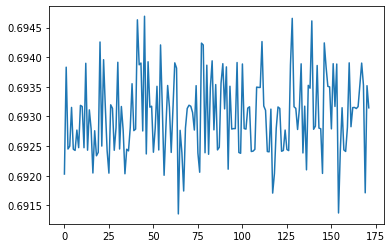

In [4]:
errors = binary_cross_entropy.get_errors()
errors = np.array(errors)
errors /= batch_size

plt.plot( errors)
plt.show()

In [8]:
validation_loader = iter(validloader)

ims, labs = validation_loader.next()

ims = np.reshape(ims, (ims.shape[0], -1))

data.set_tensor(data_tensor, 50, 50, 1)
labels.set_tensor(labs, 1, 1, 1)

out = conv1.forward(data)
out = relu1.forward(out)
#out = pool2.forward(out)
out = conv2.forward(out)
out = relu2.forward(out)
out = pool1.forward(out)
out = dense1.forward(out)
out = relu3.forward(out)
out = dense2.forward(out)
out = relu4.forward(out)
out = dense3.forward(out)
out = sigmoid.forward(out)

out_arr = out.get_tensor()

out_arr = [1 for element in out_arr if element > 0]

out_arr = np.array(out_arr)
labs = np.array(labs)


acc = np.sum(out_arr == labs)

print("Accuracy: ", acc/batch_size * 100)

Accuracy:  37.5


(16, 7, 7)


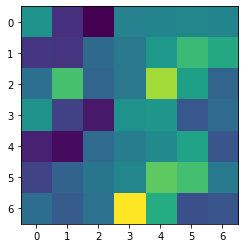

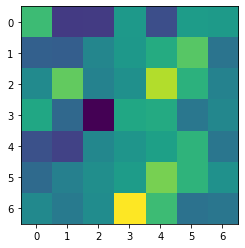

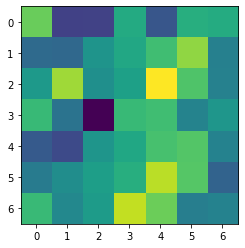

From first layer of convolution


In [23]:
conv1_filters = conv1.get_filters()
conv2_filters = conv2.get_filters()

conv1_filters = np.reshape(conv1_filters, (conv1_filters.shape[0], 7, 7))
conv2_filters = np.reshape(conv2_filters, (conv2_filters.shape[0], 5, 5, -1))

# functions to show an image
classes=("Conv1","Conv2")

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy()
    plt.imshow(img)
    plt.show()


print(conv1_filters.shape)

# show images
imshow(conv1_filters[0])
imshow(conv1_filters[1])
imshow(conv1_filters[2])
# print labels
print("From first layer of convolution")

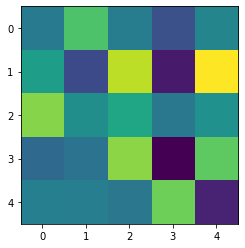

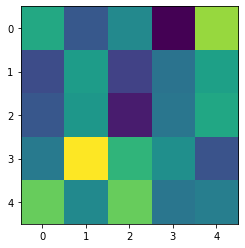

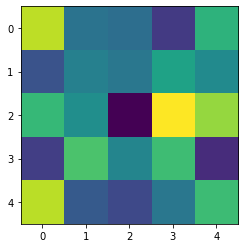

From second layer of convolution


In [26]:
# show images
imshow(conv2_filters[0, :, :, 0])
imshow(conv2_filters[0, :, :, 1])
imshow(conv2_filters[0, :, :, 2])
# print labels
print("From second layer of convolution")